In [1]:
import os
import time
import multiprocessing as mp
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import cm
import torch
from botorch.utils.transforms import unnormalize, normalize

from proteus.inference.inference import infer_from_config
from objective import run_proteus, prot_builder
from utils import get_obj

dtype = torch.double
wd = Path().cwd()
os.chdir(wd.parents[2])
base = os.getcwd()
print(base)


%matplotlib inline
%matplotlib widget

/Users/benriegler/Projects/PROTEUS


In [2]:
re_run = False # set to true if you want to create new grid of proteus runs for plotting
re_use_Y = False # set to true if grid exists and true observables did not change (need to remember associated true params)

parameters = {"struct.mass_tot" : [0.7, 3.0],
              "struct.corefrac" : [0.3, 0.9]}

bounds = torch.tensor([[0.7, 0.3], [3.0, 0.9]], dtype=dtype)

true_x1 = 2.
true_x2 = .6

true_pars = {"struct.mass_tot" : true_x1,
             "struct.corefrac" : true_x2}
observe = ["R_obs", "P_surf"]

ref = base + "/input/demos/dummy.toml"
out = "infer_toy/true/"

true_obs = dict(run_proteus(parameters=true_pars, worker=0, iter=0, observables=observe, ref_config=ref, output=out))
print(true_obs)
[format(float(v), ".17f") for k, v in true_obs.items()]

{'R_obs': np.float64(7965615.4204), 'P_surf': np.float64(16333.197934)}


['7965615.42040000017732382', '16333.19793399999980466']

In [3]:
f = prot_builder(parameters=parameters, observables=true_obs, worker=0, iter=0, ref_config=ref, output=out)

In [4]:
true_x = torch.tensor([[true_x1, true_x2]], dtype=dtype)
true_x_norm = normalize(true_x, bounds)
f(true_x_norm)

tensor([[10.]], dtype=torch.float64)

In [5]:
builder_args =  dict(parameters=parameters,
                        observables=true_obs,
                        ref_config=ref,
                        output="infer_toy/grid/")

def f_aug(x, iter, builder_args):
    f = prot_builder(
                    parameters=builder_args["parameters"],
                    observables=builder_args["observables"],
                    worker=-1,
                    iter=iter,
                    ref_config=builder_args["ref_config"],
                    output=builder_args["output"]
                    )

    return f(x)

n = 30 # needs to match potentially saved grid
unit_grid = torch.linspace(0, 1, n, dtype=dtype)
X1, X2 = torch.meshgrid(unit_grid, unit_grid, indexing="ij") # each (n, n)
X = torch.stack([X1.flatten()[:, None], X2.flatten()[:, None]], dim=-1) # (n, 1, 2)

aug_args = [(x, i, builder_args) for i, x in enumerate(X)]

In [6]:
if re_run:
    # this will take ~26 mins on an M3 MacBook
    avail_cpus = os.cpu_count() - 1

    ctx = mp.get_context("fork")
    with ctx.Pool(processes=avail_cpus) as pool:
        results = pool.starmap(f_aug, aug_args)

    Y = torch.vstack(results).reshape(n, n) # (n, n)
    os.makedirs(base + "/output/infer_toy/grid/", exist_ok=True)
    torch.save(Y, base + "/output/infer_toy/grid/Y.pt")

elif re_use_Y:
    Y = torch.load(base + "/output/infer_toy/grid/Y.pt")

else:
    # re-use simulations, but build objective values from new true observables
    # this will take ~30s
    grid_path = base + "/output/infer_toy/grid/"
    Y = get_obj(true_obs, n, grid_path)

In [7]:
print(Y.max())
idx = Y.argmax()
print(X[idx])
unnormalize(X[idx], bounds)

tensor(5.7725, dtype=torch.float64)
tensor([[0.5517, 0.4828]], dtype=torch.float64)


tensor([[1.9690, 0.5897]], dtype=torch.float64)

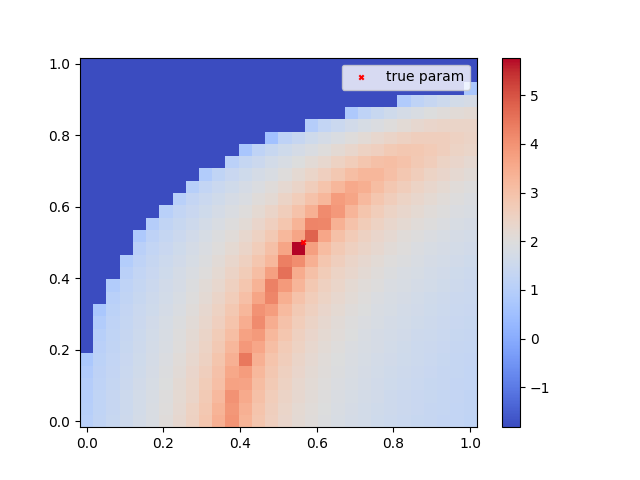

In [8]:
fig2d, ax2d = plt.subplots()
mesh = ax2d.pcolormesh(X1, X2, Y, shading="auto", cmap=cm.coolwarm)
fig2d.colorbar(mesh, ax=ax2d)
ax2d.scatter(true_x_norm[:, 0], true_x_norm[:, 1], marker="x", s=10, color = "red", label = "true param")
ax2d.legend()


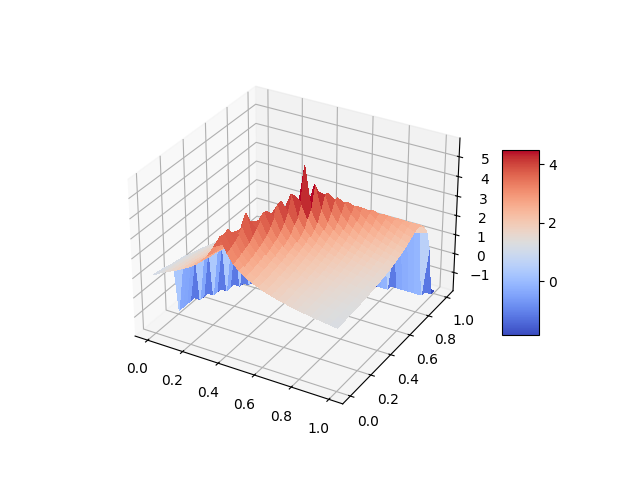

In [9]:
fig3d, ax3d = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax3d.plot_surface(X1, X2, Y, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

fig3d.colorbar(surf, shrink=0.5, aspect=5)

In [10]:
# run BO, ensure traget observables in config match the ones generated in this notebook
infer_from_config("input/ensembles/example.infer.toml")

Source for initial guess: sampling parameter space
    nsamp = 10
Initial sampling took 20.46s
Generated initial dataset with 10 points in 2-dim space
 
Starting optimisation with 6 workers and 10 initial samples
Performing 50 BO steps for a final total 60 samples
Step    1, best objective = 3.61106
Step    2, best objective = 4.76922
Step    3, best objective = 4.76922
Step    4, best objective = 4.76922
Step    5, best objective = 4.76922
Step    6, best objective = 4.76922
Step    7, best objective = 4.76922
Step    8, best objective = 4.76922
Step    9, best objective = 5.15816
Step   10, best objective = 5.15816
Step   11, best objective = 5.20974
Step   12, best objective = 5.33387
Step   13, best objective = 5.33387
Step   14, best objective = 5.33387
Step   15, best objective = 5.33387
Step   16, best objective = 5.33387
Step   17, best objective = 5.33387
Step   18, best objective = 5.33387
Step   19, best objective = 5.33387
Step   20, best objective = 5.33387
Step   21, best

In [11]:
path = base + "/output/infer_toy/BO/data.pkl"

with open(path, "rb") as f:
    D = pickle.load(f)

sampled_X = D["X"]
sampled_Y = D["Y"]

print("best sampled objective value: ", sampled_Y.max().item())

best_idx = sampled_Y.argmax()
best_X = sampled_X[best_idx][None,:]

path = base + "/output/infer_toy/BO/init.pkl"

with open(path, "rb") as f:
    D_init = pickle.load(f)

init_X = D_init["X"]

best sampled objective value:  7.4540766993181675


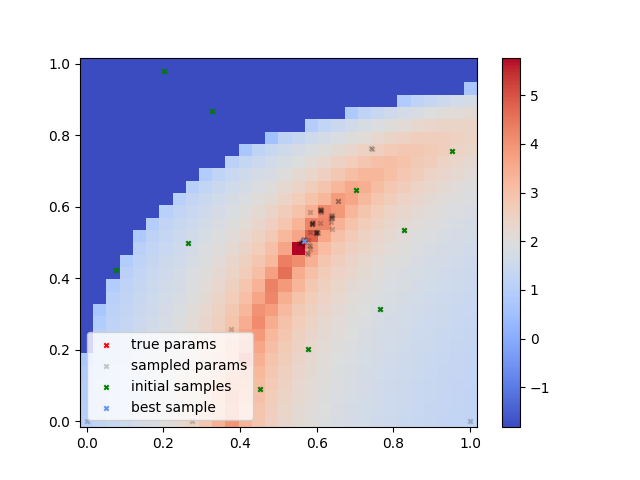

In [12]:
fig2d, ax2d = plt.subplots()
mesh = ax2d.pcolormesh(X1, X2, Y, shading="auto", cmap=cm.coolwarm)
fig2d.colorbar(mesh, ax=ax2d)
ax2d.scatter(true_x_norm[:, 0], true_x_norm[:, 1], marker="x", s=10, color = "red", label = "true params")
ax2d.scatter(sampled_X[:, 0], sampled_X[:, 1], marker="x", s=10, color= "black", label = "sampled params", alpha=0.2)
ax2d.scatter(init_X[:, 0], init_X[:, 1], marker="x", s=10, color= "green", label = "initial samples")
ax2d.scatter(best_X[:, 0], best_X[:, 1], marker="x", s=10, color= "cornflowerblue", label = "best sample")
ax2d.legend()

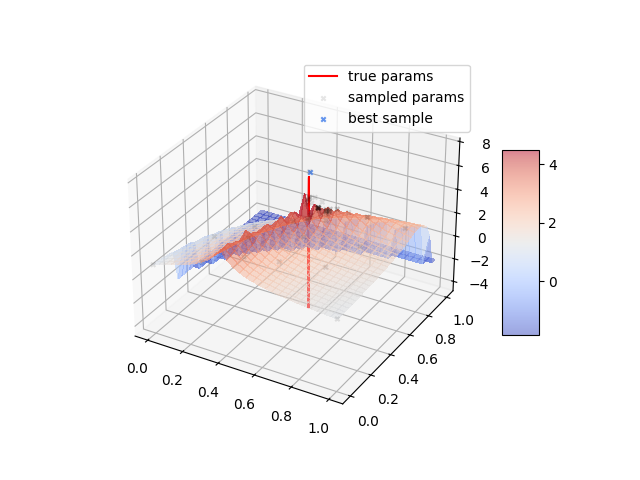

In [13]:
fig3d, ax3d = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax3d.plot_surface(X1, X2, Y, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.5)



ax3d.plot((true_x_norm[:, 0], true_x_norm[:, 0]), (true_x_norm[:, 1], true_x_norm[:, 1]), (-4, 7), color = "red", label = "true params")
ax3d.scatter(sampled_X[:, 0], sampled_X[:, 1], sampled_Y[:, 0], s=10, color= "black", marker="x", label = "sampled params", alpha=0.1)
ax3d.scatter(best_X[:, 0], best_X[:, 1], sampled_Y[:,0].max(), marker="x", s=10, color= "cornflowerblue", label = "best sample")
ax3d.legend()

fig3d.colorbar(surf, shrink=0.5, aspect=5)